# SpecUFEx Tutorial: The Geysers, California

Written by Theresa Sawi and Nate Groebner

Based on the study **Machine learning reveals cyclic changes in seismic source spectra in Geysers geothermal field** by Holtzman et al., 2018. DOI 10.1126/sciadv.aao2929

This example walks through fitting a SpecUFEx model to seismograms of approximately 5,000 microearthquakes from The Geysers geothermal field in California from 2012 to 2014. This is a subset of the 46,000 events that were analyzed in the study above. Using the features extracted by SpecUFEx, k-means clustering identifies 4 clusters of earthquake patterns that are correlated to rate of water flow into the injection wells.

## Tutorial Steps

1. Read in waveforms from hdf5 file.
2. Convert waveforms to spectrograms (filtered and median normalized)
3. Run SpecUFEx on spectrograms: Nonnegative matrix factorization followed by hidden markov model
4. Do kmeans clustering on SpecUFEx fingerprints
5. Compare clusters to paper figure 3c



### Imports

In [68]:
import datetime
import glob
import os
import h5py
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from io import StringIO
import scipy.signal as sp
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import trange
import obspy
from specufex import BayesianNonparametricNMF, BayesianHMM

## Load waveforms

The waveforms are saved to an hdf5 file. The waveforms and their IDs are loaded into numpy arrays and then stored in a pandas dataframe for easier manipulation.

In [116]:
path_waves = "./data/DATA_T1246/waves/IV/T1246/HHZ*.mseed"
path_picks = "./data/hypoDD_20161013_20161018.pha"
# path_picks_csv = "./data/hypoDD_20161013_20161018.csv"
station = "T1246"
network = "IV"

# Read waveforms

In [3]:
wave_files = glob.glob(path_waves)
wave_files.sort()
print(wave_files)
print(len(wave_files))

['./data/DATA_T1246/waves/IV/T1246/HHZ..20161013T000000Z.20161014T000000Z.mseed', './data/DATA_T1246/waves/IV/T1246/HHZ..20161014T000000Z.20161015T000000Z.mseed', './data/DATA_T1246/waves/IV/T1246/HHZ..20161015T000000Z.20161016T000000Z.mseed', './data/DATA_T1246/waves/IV/T1246/HHZ..20161016T000000Z.20161017T000000Z.mseed', './data/DATA_T1246/waves/IV/T1246/HHZ..20161017T000000Z.20161018T000000Z.mseed', './data/DATA_T1246/waves/IV/T1246/HHZ..20161018T000000Z.20161019T000000Z.mseed']
6


In [4]:
stream_raw = obspy.Stream()

for fi in wave_files:
    stream = obspy.read(fi,format='MSEED')
    stream_raw.append(stream[0])
stream_raw.sort()

6 Trace(s) in Stream:
IV.T1246..HHZ | 2016-10-12T23:59:56.550000Z - 2016-10-14T00:00:02.450000Z | 100.0 Hz, 8640591 samples
IV.T1246..HHZ | 2016-10-13T23:59:58.310000Z - 2016-10-15T00:00:02.810000Z | 100.0 Hz, 8640451 samples
IV.T1246..HHZ | 2016-10-14T23:59:58.770000Z - 2016-10-16T00:00:04.120000Z | 100.0 Hz, 8640536 samples
IV.T1246..HHZ | 2016-10-15T23:59:59.860000Z - 2016-10-17T00:00:01.280000Z | 100.0 Hz, 8640143 samples
IV.T1246..HHZ | 2016-10-16T23:59:56.950000Z - 2016-10-18T00:00:01.110000Z | 100.0 Hz, 8640417 samples
IV.T1246..HHZ | 2016-10-17T23:59:56.780000Z - 2016-10-19T00:00:01.780000Z | 100.0 Hz, 8640501 samples

# Read earthquakes and picks

In [5]:
# Read data into DataFrame
# df = pd.read_csv(StringIO(path_picks), sep='\s+', header=None)
df = pd.read_csv(path_picks,header=None)


In [120]:

# Read the text file
with open(path_picks, 'r') as file:
    lines = file.readlines()

# Filter out lines not starting with '#'

event_lines = [line.strip() for line in lines if line.startswith('#')]
# Create pandas DataFrame

df_events = pd.DataFrame([line.split() for line in event_lines])

df_events.rename({0:'#',
                1:'year',
               2:'month',
                3:'day',
                4:'hour',
                5:'minute',
                6:'second',
                7:'lat',
                8:'lon',
                9:'depth',
                14:'event_id'},
                axis=1,inplace=True)
df_events['lon'] = df_events.lon.astype(float)
df_events['lat'] = df_events.lat.astype(float)
df_events['depth'] = df_events.depth.astype(float)
print(len(df_events))

16495


In [121]:
df_events

,#,year,month,day,hour,minute,second,lat,lon,depth,10,11,12,13,event_id,15
0,#,2016,10,12,23,59,55.70,42.7615,13.2787,15.06,0.00,4.86,3.46,0.81,100001,E
1,#,2016,10,13,0,0,5.96,42.7548,13.1805,3.97,0.00,0.93,0.69,0.22,100002,E
2,#,2016,10,13,0,0,36.44,42.7412,13.1925,3.97,0.00,0.23,0.40,0.25,100003,E
3,#,2016,10,13,0,0,43.18,42.8675,13.0812,4.85,0.00,0.60,1.56,0.59,100004,E
4,#,2016,10,13,0,1,3.25,42.9337,13.0253,6.84,0.00,0.46,1.06,0.26,100005,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16490,#,2016,10,18,23,56,48.35,43.0113,13.0492,0.02,0.00,1.55,3.47,0.69,116491,E
16491,#,2016,10,18,23,57,33.28,42.8193,13.1810,3.66,0.00,0.22,0.52,0.31,116492,E
16492,#,2016,10,18,23,58,46.53,42.8825,13.2168,2.28,0.00,0.48,1.92,0.20,116493,E
16493,#,2016,10,18,23,59,12.33,42.8660,13.1770,3.58,0.00,0.35,0.70,0.27,116494,E


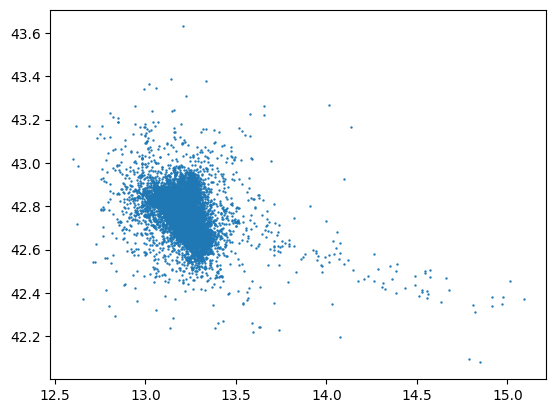

In [122]:
plt.scatter(df_events.lon,df_events.lat,s=.5)

# Assign event_ID to each line not starting with # based on preceeding event line 

In [123]:

# Initialize variables
current_event_id = None
data = []

# Iterate through the lines
for line in lines:
    line = line.strip()
    if line.startswith('#'):
        # Extract event_id from the current line starting with '#'
        current_event_id = line.split()[14]
    else:
        # For each entry not starting with '#', append it along with the event_id to the data list
        data.append([current_event_id] + line.split())

# Create pandas DataFrame
df_picks = pd.DataFrame(data, columns=['event_id', 'station', 'rel_pick_time', 'prob', 'PorS', 'component'])
df_picks.drop_duplicates(inplace=True)
# Get just P waves from HH component of netwrk station 
df_picks_sta = df_picks[(df_picks.station==network+station) & (df_picks.component=='HH') & (df_picks.PorS=='P')]

print(len(df_picks_sta))

5594


### Select a subset of the earthquakes


In [124]:
### Select a subset of the earthquakes
import random
random.seed(0)
np.random.seed(0)

num_samp = 100

random_integers = random.sample(range(0, len(df_picks_sta) + 1), num_samp)

cat = df_picks_sta.iloc[random_integers].sort_values("event_id")
df_events_subset = df_events[df_events.event_id.isin(cat.event_id)]
print(len(cat),len(df_events_subset))


100 100


# Make datetimes

In [125]:
datetime_list =  [pd.to_datetime(f"{df_events_subset.iloc[i]['year']}/{df_events_subset.iloc[i]['month']}/{df_events_subset.iloc[i]['day']} {df_events_subset.iloc[i]['hour']}:{df_events_subset.iloc[i]['minute']}:{df_events_subset.iloc[i]['second']}") for i in range(len(df_events_subset))]

df_events_subset.loc[:,'otime'] = datetime_list

df_events_subset

/var/folders/tg/19dx30mj7bx0vw7hn2lf3j440000gn/T/ipykernel_16602/1489083379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_subset.loc[:,'otime'] = datetime_list


,#,year,month,day,hour,minute,second,lat,lon,depth,10,11,12,13,event_id,15,otime
32,#,2016,10,13,0,12,15.13,42.7940,13.2150,3.82,0.00,0.23,0.43,0.29,100033,E,2016-10-13 00:12:15.130
368,#,2016,10,13,2,23,57.85,42.6878,13.2390,7.03,0.00,0.25,0.52,0.26,100369,E,2016-10-13 02:23:57.850
889,#,2016,10,13,6,17,15.35,42.6380,13.2107,7.05,0.00,0.52,0.62,0.23,100890,E,2016-10-13 06:17:15.350
1064,#,2016,10,13,7,48,10.25,42.6965,13.1633,6.86,0.00,0.22,0.55,0.25,101065,E,2016-10-13 07:48:10.250
1596,#,2016,10,13,12,51,22.31,42.9422,13.1278,3.87,0.00,0.31,0.48,0.28,101597,E,2016-10-13 12:51:22.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15049,#,2016,10,18,10,7,49.44,42.6457,13.2067,8.58,0.00,0.26,0.60,0.27,115050,E,2016-10-18 10:07:49.440
15370,#,2016,10,18,13,26,58.24,42.8022,13.1570,4.42,0.00,0.21,0.59,0.24,115371,E,2016-10-18 13:26:58.240
15932,#,2016,10,18,19,24,56.00,42.7392,13.1932,3.85,0.00,0.29,0.50,0.33,115933,E,2016-10-18 19:24:56.000
16164,#,2016,10,18,21,29,5.90,42.6102,13.2893,5.95,0.00,0.87,1.58,0.65,116165,E,2016-10-18 21:29:05.900


# Get waveforms

100%|█████████████████████████████████████████| 100/100 [00:41<00:00,  2.38it/s]


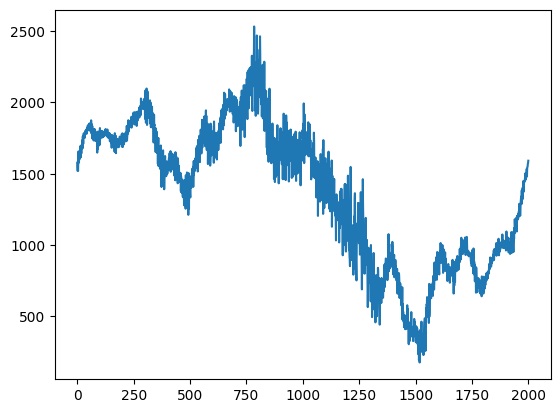

In [128]:
from tqdm import tqdm

trace_ev_list = []
otimes_list = []
lat_list = []
lon_list = []


total_iterations = len(df_events_subset)

# Iterate over DataFrame with tqdm progress bar
for i, row in tqdm(df_events_subset.iterrows(), total=total_iterations):
    evID = row.event_id
    otime = row.otime
    lat = row.lat
    lon = row.lon

    
    otimes_list.append(otime)
    lat_list.append(lat)
    lon_list.append(lon)
    
    df_picks_evID = cat[cat.event_id==evID]
    pick_lag = df_picks_evID.rel_pick_time
    

    if otime.date().day == 13:
        fi = wave_files[0]

    elif otime.date().day == 14:
        fi = wave_files[1]

    elif otime.date().day == 15:
        fi = wave_files[2]

    elif otime.date().day == 16:
        fi = wave_files[3]

    elif otime.date().day == 17: 
        fi = wave_files[4]

    else:
        fi = wave_files[5]

    stream = obspy.read(fi,format='MSEED')

    trace = stream[0]


    trace.detrend('demean')  # Demean the data
    trace.detrend('linear')  # Linear detrend the data
        

    preroll = 3
    postroll = 17

    starttime = otime + pd.Timedelta(seconds=float(pick_lag.iloc[0]) - preroll)
    endtime = otime + pd.Timedelta(seconds=float(pick_lag.iloc[0]) + postroll)    
    
    trace_ev = trace.trim(starttime = obspy.UTCDateTime(starttime), endtime = obspy.UTCDateTime(endtime))


    trace_ev_list.append(trace_ev)
    

    
cat['waveform'] = trace_ev_list
cat['otime'] = otimes_list
cat['lat'] = lat_list
cat['lon'] = lon_list
plt.plot(trace_ev_list[0])

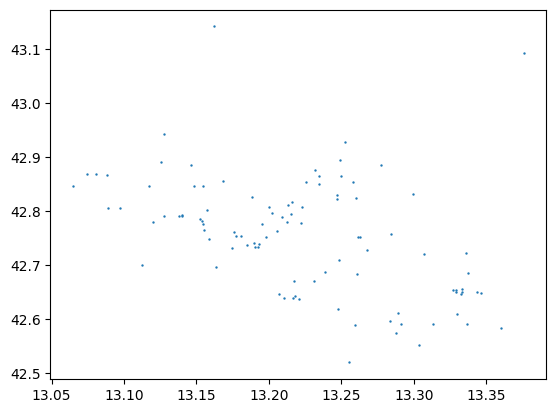

In [129]:
plt.scatter(cat.lon,cat.lat,s=.5)

# Create H5 catalog

In [130]:
with h5py.File("./data/amatrice/waveforms.h5", "w") as f:
    f.create_dataset("waveforms", data=np.stack(cat["waveform"].values))
    f.create_dataset("event_ids", data=list(cat["event_id"].values))
    f.create_dataset("otime", data=list(cat["otime"].astype('str').values))
    f.create_dataset("lat", data=list(cat["lat"].values))
    f.create_dataset("lon", data=list(cat["lon"].values))
